In [ ]:
!pip install datasets
!pip install transformers
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00


**IMPORTING LIBRARIES**

In [ ]:
import pandas as pd
import random
import numpy as np
import torch
import evaluate
from datasets import load_dataset_builders
from datasets import DatasetDict
from datasets import Dataset
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
from sklearn import metrics

# **EXPLORING DATASET**

load_dataset_builder -> allows us to check features and informantion about dataset without downloading it

Here we got to know dataset have 2 columns

1. text -> String
2. label -> [pos,neg]

In [ ]:
ds=load_dataset_builder("imdb")
ds.info.features

Downloading the dataset

In [ ]:

#downloading dataset
from datasets import load_dataset
dataset=load_dataset("imdb")

Dataset consists of 3 subsections ->train(25000) , test(25000), unsupervised(50000)



In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Plotting the graph->


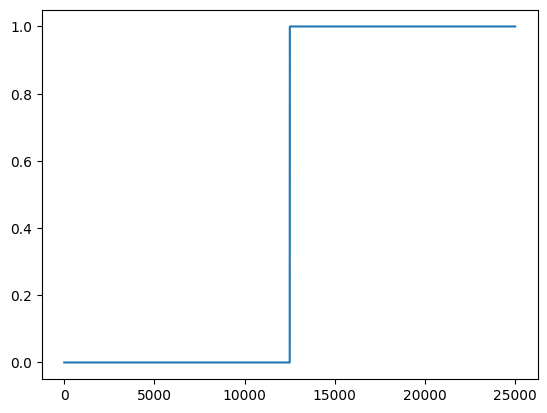

In [9]:
label_train=dataset["train"]["label"]
import matplotlib.pyplot as plt
plt.plot(label_train)
plt.show()
# This graph clearly show that first 12500 examples are with label 0 and next 12500 examples are with label 1

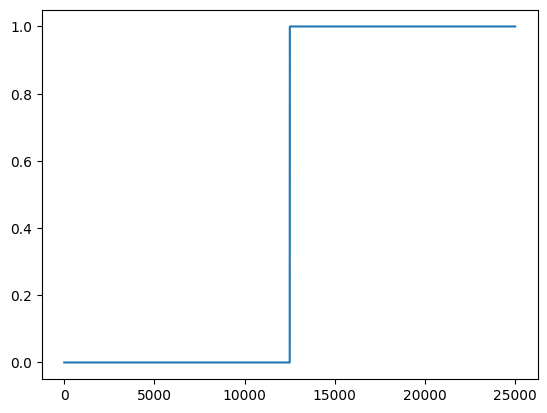

In [10]:
label_train=dataset["test"]["label"]
import matplotlib.pyplot as plt
plt.plot(label_train)
plt.show()
# This graph clearly show that first 12500 examples are with label 0 and next 12500 examples are with label 1

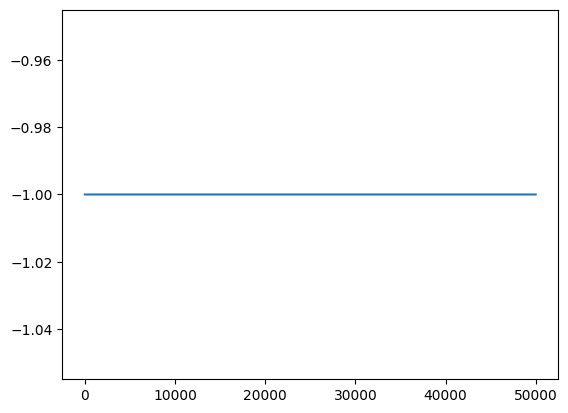

In [12]:
label_train=dataset["unsupervised"]["label"]
import matplotlib.pyplot as plt
plt.plot(label_train)
plt.show()
#here all the samples ares completely labeled as -1
#we have to remove this section entirely

# **CREATION OF DATASET**

create a new dataset from the existing one with 5k rows

split->train(80%),val(10%),test(10%)

In [14]:
#randomly choosing index of 2500 negative examples
input=range(0,12500)
neg_index=np.sort((random.sample(input,2500)))
#randomly choosing index of 2500 positive examples
input=range(12500,25000)
pos_index=np.sort((random.sample(input,2500)))

#final_index_train=neg_index[:2000]+pos_index[:2000] and then shuffle it
final_index_train=np.concatenate((neg_index[0:2000],pos_index[0:2000]))
np.random.shuffle(final_index_train)
#final_index_val=neg_index[2000:2250]+pos_index[2000:2250] and then shuffle it
final_index_val=np.concatenate((neg_index[2000:2250],pos_index[2000:2250]))
np.random.shuffle(final_index_val)
#final_index_val=neg_index[2250:2500]+pos_index[2250:2500] and then shuffle it
final_index_test=np.concatenate((neg_index[2250:2500],pos_index[2250:2500]))
np.random.shuffle(final_index_test)

#So each section have equal number of positive and negative samples->
#test has 2000 pos and 2000 neg
#val has 250 pos and 250 neg
#test has 250 pos and 250 neg

valid_indices_train=final_index_train.tolist()
valid_indices_val=final_index_val.tolist()
valid_indices_test=final_index_test.tolist()

# making Dataset according to hugging face format from 3 dictionaries
train_data={
    "text":[dataset["train"][i]["text"] for i in valid_indices_train],
    "label":[dataset["train"][i]["label"] for i in valid_indices_train]
}
train_dataset=Dataset.from_dict(train_data)
val_data={
    "text":[dataset["train"][i]["text"] for i in valid_indices_val],
    "label":[dataset["train"][i]["label"] for i in valid_indices_val]
}
val_dataset=Dataset.from_dict(val_data)
test_data={
    "text":[dataset["train"][i]["text"] for i in valid_indices_test],
    "label":[dataset["train"][i]["label"] for i in valid_indices_test]
}
test_dataset=Dataset.from_dict(test_data)

#combining the three Dict to form the overall dataset
dataset=DatasetDict({"train":train_dataset,"val":val_dataset,"test":test_dataset})

In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4000
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
})

# **TOKENIZER SETUP**

In [22]:
#Downloading the tokenizer from the pretrained model
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")

# **TOKENIZING DATASET**

In [23]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Tokenizing the dataset
tokenized_datasets = dataset.map(tokenize_function)

tokenized_datasets

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4000
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
})

we have to remove text columns from the dataset and columns with labels should be name "labels"

this is how model expect the dataset during training

In [24]:
# Remove the text feilds
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
# label->labels
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# convert the dataset to pytorch format
tokenized_datasets.set_format("torch")

In [25]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 4000
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
})

# **DATALOADERS**

Making the dataloaders to make iterable objects and for dividing the datsets to batches

In [29]:
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=8)
val_dataloader = DataLoader(tokenized_datasets["val"], shuffle=True, batch_size=8)
test_dataloader = DataLoader(tokenized_datasets["test"], shuffle=True,batch_size=8)

# **HYPERPARAMETERS**

In [34]:
lr=3e-05
num_epochs = 5
num_warmup_steps=5
num_training_steps = num_epochs * len(train_dataloader)

# **LOADING MODEL**

In [27]:
# num_labels=numbers of classes ->2
model = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base",num_labels=2)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Putting model on device(cuda or cpu)

In [32]:
#device = cuda if cuda available or else cpu
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

# **OPTIMIZER SETUP**

In [33]:
optimizer = AdamW(model.parameters(), lr=lr)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

# **TRAINING LOOP**

In [35]:
progress_bar = tqdm(range(num_training_steps))

trainingEpoch_loss = []
Steps_final=[]

model.train()

for epoch in range(num_epochs):
  step_loss = []
  for i,batch in enumerate(train_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    loss.backward()

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)

    step_loss.append(loss.item())
    if (i+1) % 50 == 0:
      print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')
  Steps_final.append(step_loss)
  trainingEpoch_loss.append(np.array(step_loss).mean())

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch [1/6], Step [50/500], Loss: 0.3174
Epoch [1/6], Step [100/500], Loss: 0.3755
Epoch [1/6], Step [150/500], Loss: 0.3517
Epoch [1/6], Step [200/500], Loss: 0.4626
Epoch [1/6], Step [250/500], Loss: 0.0806
Epoch [1/6], Step [300/500], Loss: 0.6169
Epoch [1/6], Step [350/500], Loss: 0.6939
Epoch [1/6], Step [400/500], Loss: 0.0792
Epoch [1/6], Step [450/500], Loss: 0.0243
Epoch [1/6], Step [500/500], Loss: 0.1090
Epoch [2/6], Step [50/500], Loss: 0.0382
Epoch [2/6], Step [100/500], Loss: 0.3586
Epoch [2/6], Step [150/500], Loss: 0.3108
Epoch [2/6], Step [200/500], Loss: 0.0908
Epoch [2/6], Step [250/500], Loss: 0.1098
Epoch [2/6], Step [300/500], Loss: 0.0221
Epoch [2/6], Step [350/500], Loss: 0.0111
Epoch [2/6], Step [400/500], Loss: 0.2257
Epoch [2/6], Step [450/500], Loss: 0.0279
Epoch [2/6], Step [500/500], Loss: 0.1158
Epoch [3/6], Step [50/500], Loss: 0.0515
Epoch [3/6], Step [100/500], Loss: 0.0575
Epoch [3/6], Step [150/500], Loss: 0.0202
Epoch [3/6], Step [200/500], Loss: 0.

# **GRAPHS FOR TRAINING**

LOSS VS EPOCH

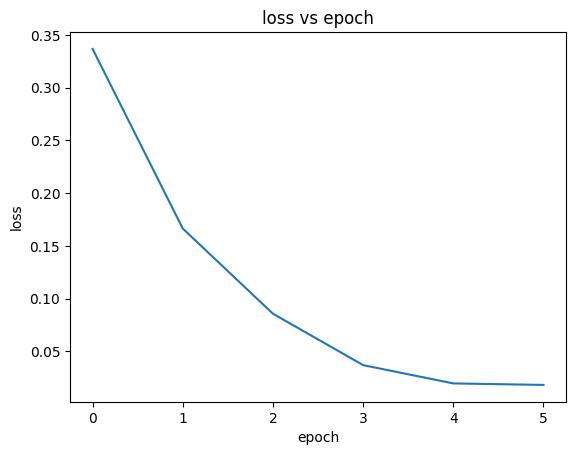

In [47]:
from matplotlib import pyplot as plt
plt.plot(trainingEpoch_loss)
plt.title("loss vs epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

LOSS VS STEP

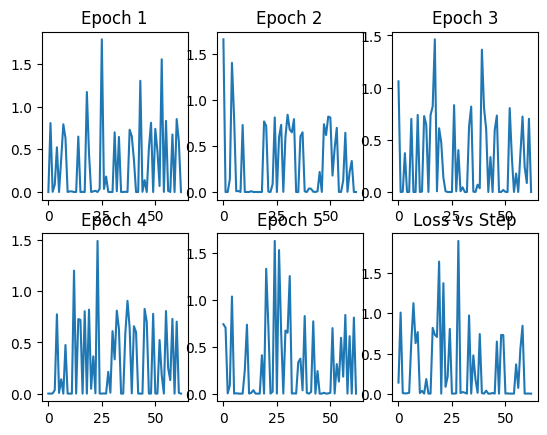

In [59]:
figure,axis=plt.subplots(2,3)

axis[0,0].plot(Steps_final[0])
axis[0,0].set_title("Epoch 1")
axis[0,1].plot(Steps_final[1])
axis[0,1].set_title("Epoch 2")
axis[0,2].plot(Steps_final[2])
axis[0,2].set_title("Epoch 3")
axis[1,0].plot(Steps_final[3])
axis[1,0].set_title("Epoch 4")
axis[1,1].plot(Steps_final[4])
axis[1,1].set_title("Epoch 5")
axis[1,2].plot(Steps_final[5])
axis[1,2].set_title("Epoch 6")

plt.title("Loss vs Step")

plt.show()

# **GRAPHS FOR VAL DATA**

In [52]:
model.eval()
validationEpoch_loss = []
Steps_final=[]

for epoch in range(num_epochs):
  step_loss = []
  for i,batch in enumerate(val_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss

    step_loss.append(loss.item())

  Steps_final.append(step_loss)
  validationEpoch_loss.append(np.array(step_loss).mean())

LOSS VS EPOCH

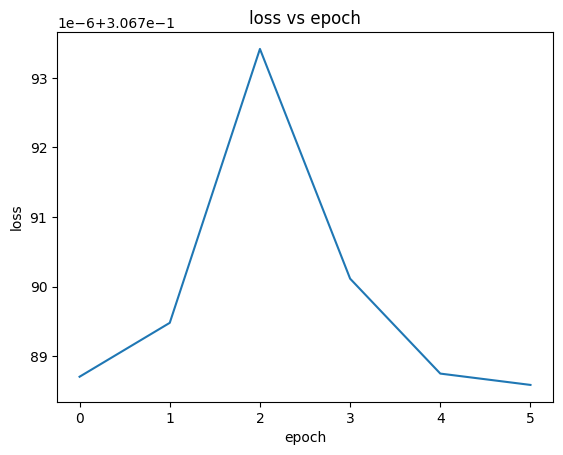

In [58]:
from matplotlib import pyplot as plt
plt.plot(validationEpoch_loss)
plt.title("loss vs epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

LOSS VS STEP

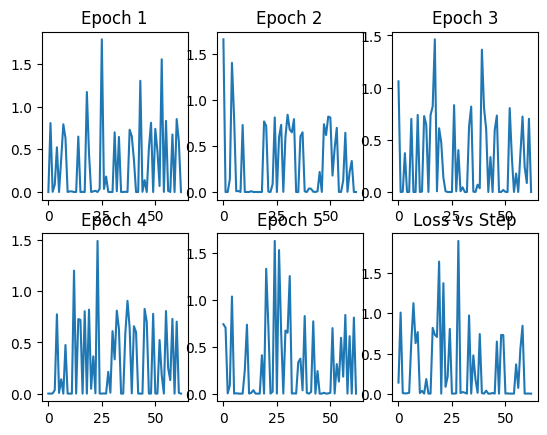

In [61]:
figure,axis=plt.subplots(2,3)

axis[0,0].plot(Steps_final[0])
axis[0,0].set_title("Epoch 1")
axis[0,1].plot(Steps_final[1])
axis[0,1].set_title("Epoch 2")
axis[0,2].plot(Steps_final[2])
axis[0,2].set_title("Epoch 3")
axis[1,0].plot(Steps_final[3])
axis[1,0].set_title("Epoch 4")
axis[1,1].plot(Steps_final[4])
axis[1,1].set_title("Epoch 5")
axis[1,2].plot(Steps_final[5])
axis[1,2].set_title("Epoch 6")

plt.title("Loss vs Step")
plt.show()

# **EVALUATION**

Loss on training data

In [78]:
model.eval()
trainEpoch_loss = []

for i,batch in enumerate(train_dataloader):
  batch = {k: v.to(device) for k, v in batch.items()}
  outputs = model(**batch)
  loss = outputs.loss
  trainEpoch_loss.append(loss.item())

train_loss_final=np.array(trainEpoch_loss).mean()
print("loss for train data->")
print(train_loss_final)

0.015547359010437503


Loss on val data

In [80]:
model.eval()
valEpoch_loss = []

for i,batch in enumerate(val_dataloader):
  batch = {k: v.to(device) for k, v in batch.items()}
  outputs = model(**batch)
  loss = outputs.loss
  valEpoch_loss.append(loss.item())

val_loss_final=np.array(valEpoch_loss).mean()
print("loss for val data->")
print(val_loss_final)

0.3143065404313217


Accuracy Recall F1 Precision on train data

In [72]:
metric = evaluate.combine(["accuracy", "f1", "precision", "recall"])

model.eval()
for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    metric.add_batch(predictions=predictions, references=batch["labels"])

print("Metrices for Train Data")
metric.compute()

{'accuracy': 0.997,
 'f1': 0.997002997002997,
 'precision': 0.9960079840319361,
 'recall': 0.998}

Accuracy Recall F1 Precision on val data

In [75]:
metric = evaluate.combine(["accuracy", "f1", "precision", "recall"])

model.eval()
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    metric.add_batch(predictions=predictions, references=batch["labels"])

print("Metrices for Val Data")
metric.compute()

{'accuracy': 0.932,
 'f1': 0.931726907630522,
 'precision': 0.9354838709677419,
 'recall': 0.928}

Q>What is the metric that you are using for evaluation and why?

Ans>I have used four commonly used metrics for evaluating classifier performance:
1. Accuracy: The proportion of correct predictions out of the total predictions.
2. Precision: The proportion of true positive predictions out of the total positive predictions (precision = true positives / (true positives + false positives)).
3. Recall (Sensitivity or True Positive Rate): The proportion of true positive predictions out of the total actual positive instances (recall = true positives / (true positives + false negatives)).
4. F1 Score: The harmonic mean of precision and recall, providing a balance between the two metrics (F1 score = 2 * ((precision * recall) / (precision + recall))).

These metrics help assess the classifier’s effectiveness in correctly classifying instances of different classes.

The reason i chose these metrices are balanced nature of my dataset -> these matrices genrally works well then all the classes have equal represntation in training and val data

Q>Is the model properly trained or is the model underfitting/overfitting?

Ans> Loss_train_data is quite low than the Loss_val_data
Besides this other metrices like accuracy ,recall etc is higher for training data than val data shows some degree of overfitting in on the training data

This can be reduced the incresing the size of dataset or by introducing a regularization term in loss

# **FINAL RESULT ON TEST DATA**

METRICES ON TEST DATA

In [64]:
metric = evaluate.combine(["accuracy", "f1", "precision", "recall"])
pred=[]
real=[]
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    a=predictions.tolist()
    b=batch["labels"].tolist()
    for i in a:
     pred.append(i)
    for i in b:
     real.append(i)

    metric.add_batch(predictions=predictions, references=batch["labels"])
print("final result for the test data is ->")
metric.compute()

{'accuracy': 0.926,
 'f1': 0.9275929549902151,
 'precision': 0.9080459770114943,
 'recall': 0.948}

CONFUSION MATRIX

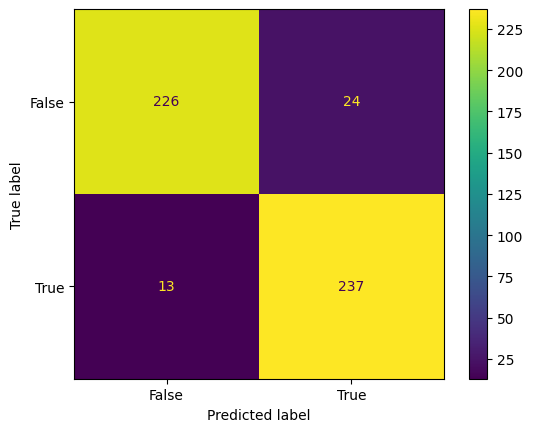

In [65]:
confusion_matrix = metrics.confusion_matrix(real, pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [67]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/task_model.pt")
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()